## **INTRODUÇÃO**


O objetivo deste Projeto é implementar e avaliar um modelo YOLO11x para a detecção automática de defeitos em PCBs. O modelo foi treinado e testado utilizando o dataset PCB Defects, disponível no Kaggle

Neste projeto, foi utilizado o modelo YOLOv11, pois à sua capacidade de processar imagens rapidamente é o que o torna ideal para eficiência e precisão em tarefas de detecção de objetos em tempo real, como a inspeção de placas de circuito impresso (PCBs).

O modelo foi configurado para detectar seis tipos de defeitos específicos que podem comprometer a funcionalidade das PCBs:

    Missing Hole: Buracos ausentes no circuito.
    Mouse Bite: Pequenos "rasgos" ou falhas no contorno.
    Open Circuit: Interrupções no circuito que causam falhas elétricas.
    Short: Conexões indesejadas entre condutores.
    Spur: Protuberâncias não planejadas no circuito.
    Spurious Copper: Resíduos de cobre fora do design esperado.



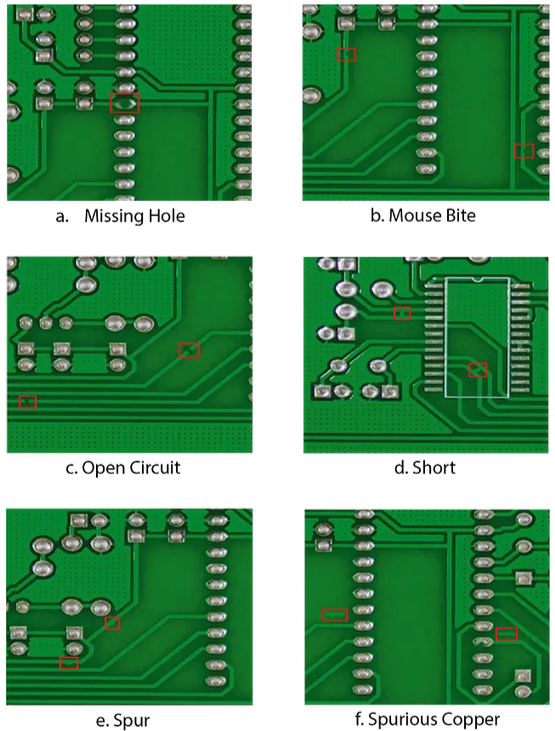

O treinamento do YOLOv11 foi realizado utilizando pesos pré-treinados (yolo11x.pt), permitindo que o modelo aproveite o conhecimento prévio para ajustar-se às características específicas do dataset de PCBs.

Além disso, foram aplicadas técnicas de transformação de dados para aumentar a diversidade do conjunto de treinamento, melhorando a robustez e a capacidade de generalização do modelo. O objetivo final é criar um modelo eficiente, capaz de identificar defeitos em PCBs com alta precisão e confiabilidade.

## **DATASET**

O dataset utilizado neste projeto foi criado com base em um dataset público disponível na plataforma Kaggle, denominado "PCB Defects" (https://www.kaggle.com/datasets/akhatova/pcb-defects). Esse dataset original contém diversas imagens relacionadas a defeitos simulados em placas de circuito impresso (PCBs). No entanto, para este projeto, apenas as imagens dos defeitos simulados foram utilizadas, totalizando 693 imagens e seus respectivos labels.

**Processamento e Aumento de Dados (Data Augmentation)**  

Para enriquecer o dataset e torná-lo mais robusto para cenários reais, onde as condições de captura das imagens podem variar significativamente, foi utilizado os recursos de data augmentation disponíveis na plataforma Roboflow. Os seguintes efeitos foram aplicados às imagens originais:

    Adição de ruídos: Simulação de interferências em imagens.
    Rotação: Alteração do ângulo das imagens para representar diferentes perspectivas.
    Sombras: Inclusão de sombras para replicar condições de iluminação adversas.
    Ajuste de claridade: Modificação da exposição e brilho.
    Blur: Desfoque para simular condições de captura não ideais.

Essas técnicas resultaram na criação de 2243 novas imagens e seus respectivos labels, com o objetivo de melhorar a generalização do modelo para situações realísticas.  

**Organização do Dataset**  

O dataset final foi estruturado em três pastas principais para facilitar a organização, o treinamento e a conversão dos labels para o formato adequado do modelo YOLO:

    JPG_files: Contém todas as imagens (originais e aumentadas) em formato JPG.
    XML_files: Contém os arquivos de labels no formato Pascal VOC (XML), oriundos do dataset original. Esses arquivos foram separados dos demais para facilitar a conversão de formato.
    TXT_files: Contém os labels das imagens (inclusive as 2243 imagens aumentadas) já convertidos para o formato TXT, aceito pelo modelo YOLO.

Criação de Dados Adicionais para Teste

Para complementar o processo de validação, a biblioteca Albumentations foi utilizada para gerar mais 588 novas imagens e labels. Esses dados adicionais foram criados exclusivamente para serem utilizados no conjunto de teste, garantindo maior diversidade e representatividade nos cenários avaliados.
Resumo

No total, o dataset foi ampliado e preparado para o treinamento e validação do modelo YOLO com o seguinte quantitativo de imagens e labels:

    693 imagens originais e labels oriundos do dataset inicial.
    2243 imagens aumentadas e labels gerados via Roboflow.
    588 imagens adicionais e labels criados para o conjunto de teste.

Essa abordagem garantiu um dataset diversificado, organizado e adaptado para o treinamento de um modelo robusto e eficiente na detecção de defeitos em PCBs.

## **SETUP E DOWNLOAD**

Instalação de bibliotecas essenciais como ultralytics e albumentations.

In [ ]:
!pip install ultralytics
!pip install gdown
!pip install -U albumentations
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 40.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
import os
import shutil
import random
import cv2
import xml.etree.ElementTree as ET
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gradio as gr
import torch
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from google.colab import files

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Download e extração do dataset utilizando '!gdown' a partir do link do arquivo salvo no drive.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1KdX04ZdphxMcQa0hAnaDNy_kwVv--7C1/view?usp=sharing
!unzip /content/PCB_Dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PCB_Dataset/JPG_files/04_short_10_jpg.rf.277d6bfc7fe25389618587db4fbc35e8.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_10_jpg.rf.31c618f321da9d304cf3c5270f099ccb.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_10_jpg.rf.831c097ce283710839707373c54027ea.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_11.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_11_jpg.rf.16be7c7009314e810dde130b6b89a6f7.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_11_jpg.rf.28a541fb4dd8bab047ef80a502907e11.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_11_jpg.rf.ca745127840d4e5d43fe2fedabc16182.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_12.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_12_jpg.rf.17c35861d3a85795add64770e9603791.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_12_jpg.rf.1e207eff33d45fbc5962d3487a35c1e9.jpg  
  inflating: PCB_Dataset/JPG_files/04_short_12_jpg.rf.445cfae153e96a529157398d8fababa8.jpg 

## **ORGANIZAÇÃO DE ARQUIVOS DO DATASET**

Conversão de anotações XML no formato Pascal VOC para formato aceito pelo YOLO.

In [ ]:
xml_folder = "/content/PCB_Dataset/XML_files"
output_folder = "/content/PCB_Dataset/TXT_files"
classes = [
    "missing_hole",
    "mouse_bite",
    "open_circuit",
    "short",
    "spur",
    "spurious_copper"
]

os.makedirs(output_folder, exist_ok=True)

def convert_bbox(size, box):

    dw, dh = 1.0 / size[0], 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w, h = box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

def process_xml_file(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_file = root.find("filename").text
    txt_path = os.path.join(output_folder, os.path.splitext(image_file)[0] + ".txt")

    size = root.find("size")
    width, height = int(size.find("width").text), int(size.find("height").text)

    with open(txt_path, "w") as f:
        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in classes:
                continue

            class_id = classes.index(class_name)
            bndbox = obj.find("bndbox")
            bbox = convert_bbox(
                (width, height),
                (
                    float(bndbox.find("xmin").text),
                    float(bndbox.find("xmax").text),
                    float(bndbox.find("ymin").text),
                    float(bndbox.find("ymax").text),
                ),
            )
            f.write(f"{class_id} {' '.join(map(str, bbox))}\n")

for xml_file in filter(lambda f: f.endswith(".xml"), os.listdir(xml_folder)):
    process_xml_file(os.path.join(xml_folder, xml_file))

print("Conversão concluída!")


Conversão concluída!


Criação de uma estrutura organizada para armazenar as imagens e os rótulos em pastas distintas para train, val.

In [ ]:
images_folder = "/content/PCB_Dataset/JPG_files"
labels_folder = "/content/PCB_Dataset/TXT_files"
output_folder = "/content/PCB_Dataset/Dataset_organized"

train_ratio = 0.8

subfolders = ["images/train", "images/val", "labels/train", "labels/val"]

for subfolder in subfolders:
    os.makedirs(os.path.join(output_folder, subfolder), exist_ok=True)

images = [f for f in os.listdir(images_folder) if f.endswith(".jpg")]
random.shuffle(images)

train_count = int(len(images) * train_ratio)
train_images, val_images = images[:train_count], images[train_count:]

def move_files(file_list, src_folder, dest_folder, extension):

    for file_name in file_list:
        src_path = os.path.join(src_folder, f"{os.path.splitext(file_name)[0]}.{extension}")
        dest_path = os.path.join(dest_folder, f"{os.path.splitext(file_name)[0]}.{extension}")
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

file_mapping = [
    (train_images, images_folder, "images/train", "jpg"),
    (val_images, images_folder, "images/val", "jpg"),
    (train_images, labels_folder, "labels/train", "txt"),
    (val_images, labels_folder, "labels/val", "txt"),
]

for file_list, src_folder, dest_subfolder, extension in file_mapping:
    move_files(file_list, src_folder, os.path.join(output_folder, dest_subfolder), extension)

print("Organização concluída!")

Organização concluída!


Criação dos arquivos de teste.
Foi utilizada a biblioteca Albumentations para transformar as imagens e rótulos para teste.

In [ ]:
transform_test = A.Compose([
    A.Resize(640, 640),
    ToTensorV2()
])

test_images_folder = "/content/PCB_Dataset/Dataset_organized/images/test"
test_labels_folder = "/content/PCB_Dataset/Dataset_organized/labels/test"
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(test_labels_folder, exist_ok=True)

def process_test_files(image_names, images_folder, labels_folder, test_images_folder, test_labels_folder):

    for image_name in image_names:
        img_path = os.path.join(images_folder, image_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        augmented = transform_test(image=img)['image']

        cv2.imwrite(
            os.path.join(test_images_folder, image_name),
            augmented.numpy().transpose(1, 2, 0)[..., ::-1]
        )

        shutil.copy(
            os.path.join(labels_folder, os.path.splitext(image_name)[0] + ".txt"),
            os.path.join(test_labels_folder, os.path.splitext(image_name)[0] + ".txt")
        )

process_test_files(val_images, images_folder, labels_folder, test_images_folder, test_labels_folder)

print("Arquivos de teste criados!")

Arquivos de teste criados!


## **TREINAMENTO DO MODELO**

In [ ]:
dataset_config = """
train: /content/PCB_Dataset/Dataset_organized/images/train
val: /content/PCB_Dataset/Dataset_organized/images/val
test: /content/PCB_Dataset/Dataset_organized/images/test

nc: 6
names: [
    "missing_hole",
    "mouse_bite",
    "open_circuit",
    "short",
    "spur",
    "spurious_copper"
    ]
"""
with open("dataset.yaml", "w") as f:
    f.write(dataset_config)
print("Arquivo dataset.yaml criado!")

Arquivo dataset.yaml criado!


In [ ]:
model = YOLO('yolo11x.pt')

history = model.train(
    data='/content/dataset.yaml',
    epochs=200,
    imgsz=640,
    batch=-1,
    patience=15,
    lr0=1e-3,
    conf=0.4,
    box=5.0,
    cls=0.7,
    dfl=2.0,
    val=True,
    augment=True,
    plots=True,
    optimizer='AdamW',
)

files.download('/content/runs/detect/train/weights/best.pt')

100%|██████████| 109M/109M [00:00<00:00, 418MB/s] 


Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/dataset.yaml, epochs=200, time=None, patience=15, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.4, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 130MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 395MB/s]


AMP: checks passed ✅


train: Scanning /content/PCB_Dataset/Dataset_organized/labels/train... 2348 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2348/2348 [00:01<00:00, 1188.06it/s]

train: New cache created: /content/PCB_Dataset/Dataset_organized/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA L4) 22.17G total, 0.48G reserved, 0.47G allocated, 21.21G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    56880706       195.5         2.296         113.6         392.2        (1, 3, 640, 640)                    list
    56880706         391         3.288         67.88         99.83        (2, 3, 640, 640)                    list
    56880706       781.9         5.245         81.92         95.76        (4, 3, 640, 640)                    list
    56880706        1564         8.974         105.4         144.9        (8, 3, 640, 640)                    list
    56880706        3128        16

train: Scanning /content/PCB_Dataset/Dataset_organized/labels/train.cache... 2348 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2348/2348 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/PCB_Dataset/Dataset_organized/labels/val... 588 images, 0 backgrounds, 0 corrupt: 100%|██████████| 588/588 [00:00<00:00, 952.85it/s]


val: New cache created: /content/PCB_Dataset/Dataset_organized/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.00046875), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      12.9G      1.597      3.656      1.549         40        640: 100%|██████████| 196/196 [01:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]

                   all        588       2464      0.722      0.475      0.619      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      12.8G      1.372      2.079      1.378         47        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]

                   all        588       2464      0.789      0.576      0.702      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      12.9G      1.318      1.878      1.356         45        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]

                   all        588       2464      0.856      0.617      0.753      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      12.9G      1.281      1.741      1.349         40        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]

                   all        588       2464      0.848       0.78      0.859       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      12.9G      1.246      1.609       1.33         70        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.863      0.788      0.844      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      12.7G      1.229      1.533      1.313         49        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        588       2464      0.843      0.792      0.827      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      12.9G      1.212      1.463      1.307         35        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]

                   all        588       2464      0.895      0.817      0.884      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      12.9G       1.18      1.416      1.292         51        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.879      0.859       0.91      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      12.8G      1.185      1.349      1.292         66        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        588       2464      0.921      0.872      0.915      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      12.9G      1.157      1.322      1.278         52        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        588       2464      0.937      0.858      0.912      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      12.8G      1.145      1.306      1.275         58        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        588       2464       0.92      0.864      0.906      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      12.9G       1.12       1.27      1.269         47        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        588       2464      0.953      0.898      0.943      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      12.9G      1.103      1.206      1.258         50        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.933      0.907      0.941      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      12.9G      1.079      1.172      1.252         59        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.962      0.895      0.936      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      12.9G      1.098      1.185      1.259         24        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464       0.95      0.908      0.941      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      12.7G      1.077      1.153      1.238         53        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.972      0.921      0.952      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      12.9G      1.072      1.159      1.248         45        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.962      0.904      0.945      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      12.9G      1.075      1.146      1.246         65        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.972      0.901      0.941      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      12.9G      1.063      1.137       1.24         56        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.962      0.929      0.956       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      12.9G       1.05      1.107      1.235         43        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.962      0.913      0.947      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      12.8G      1.045      1.104      1.226         73        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        588       2464      0.964       0.91      0.947      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      12.9G      1.022      1.061      1.222         41        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.956      0.925      0.958      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      12.9G      1.022      1.084      1.222         46        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.961      0.931      0.958      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      12.9G       1.03      1.091      1.223         23        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.968      0.932      0.958      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      12.9G      1.009      1.076       1.21         65        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.973      0.917      0.953      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      12.8G     0.9998      1.046      1.205         32        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.972      0.934       0.96      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      12.9G      0.989      1.024      1.204         40        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.968      0.918      0.952      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      12.8G     0.9964      1.044      1.204         42        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.975      0.943      0.966      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      12.9G     0.9674     0.9888      1.195         48        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.962      0.947      0.964       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      12.9G     0.9691     0.9907      1.191         46        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.968      0.941      0.963      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      12.8G      0.964     0.9769      1.192         49        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.977      0.937      0.962      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      12.9G     0.9704     0.9895      1.195         48        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.978      0.939      0.963       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      12.9G     0.9511     0.9733      1.189         63        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.977       0.95       0.97       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      12.9G     0.9404     0.9712      1.184         65        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.981      0.946      0.966      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      12.8G     0.9485     0.9725      1.183         54        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.968       0.95      0.968      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      12.8G     0.9253     0.9375      1.174         32        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.977      0.945      0.967      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      12.9G     0.9275     0.9385      1.179         39        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.979      0.948      0.968        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      12.9G     0.9183     0.9419      1.172         63        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.976      0.947      0.968      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      12.9G     0.9196     0.9191      1.172         52        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.98      0.951       0.97      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      12.9G     0.9111     0.9274       1.17         43        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.976      0.953      0.972      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      12.7G      0.896     0.8984      1.168         38        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.975      0.944      0.967        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      12.9G     0.9058     0.9186      1.167         65        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.978       0.95      0.968      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      12.9G     0.8788     0.8875      1.158         42        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.982      0.946      0.969      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      12.9G     0.8889     0.8893      1.167         31        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.982      0.942      0.967      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      12.9G     0.8787     0.8981      1.163         29        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.974      0.953      0.969      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      12.7G     0.8928     0.9115      1.161         31        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.976      0.961      0.974      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      12.9G     0.8957     0.8997       1.17         40        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.984      0.955      0.973      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      12.9G      0.872     0.8788      1.159         27        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.983      0.957      0.974       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      12.9G     0.8508     0.8505      1.152         47        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.977      0.963      0.976      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      12.9G      0.853     0.8607      1.147         42        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.983       0.96      0.975      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      12.8G       0.85     0.8421      1.152         62        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.982      0.966      0.979      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      12.9G      0.839     0.8387      1.147         31        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.982       0.96      0.974      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      12.9G     0.8425     0.8357      1.152         69        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.984      0.954      0.971       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      12.9G     0.8433     0.8332      1.145         30        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.982      0.961      0.976      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      12.8G     0.8279     0.8197       1.14         52        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464       0.99      0.955      0.974      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      12.8G     0.8253     0.8241      1.143         61        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.987      0.957      0.973      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      12.9G     0.8167     0.8128      1.144         63        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985      0.957      0.974       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      12.9G     0.8168     0.8217      1.142         35        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.986       0.96      0.976      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      12.9G      0.803     0.8087      1.139         41        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985       0.96      0.976      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      12.8G     0.8244      0.805      1.139         56        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.987      0.959      0.978      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      12.8G     0.7913     0.7924      1.132         41        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.987      0.963      0.977      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      12.9G      0.785      0.786      1.136         48        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.981      0.961      0.976      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      12.9G     0.7741     0.7714      1.133         57        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.975      0.965      0.977       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      12.9G     0.7857     0.7847      1.131         39        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.98      0.964      0.977       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      12.8G     0.7818     0.7761      1.133         39        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985      0.964      0.978      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      12.7G     0.7693     0.7749      1.133         42        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.984      0.956      0.978      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      12.9G     0.7762     0.7679      1.128         56        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.983       0.97       0.98      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      12.9G     0.7606     0.7519      1.131         50        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985      0.967      0.979      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      12.9G     0.7611     0.7582      1.129         57        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985      0.967      0.979      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      12.8G     0.7573     0.7518      1.128         34        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.963      0.977      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      12.7G     0.7545     0.7568      1.125         38        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.986       0.96      0.977      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      12.9G     0.7509     0.7483      1.121         35        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985      0.968      0.981      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      12.9G     0.7487     0.7403       1.12         48        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.967      0.979      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      12.8G     0.7286     0.7175      1.119         24        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.987      0.972      0.983      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      12.8G     0.7241     0.7252      1.119         39        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.966       0.98      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      12.7G     0.7427     0.7559      1.122         63        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.965      0.979      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      12.9G     0.7329      0.729      1.117         19        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.964      0.978      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      12.9G     0.7273     0.7256      1.115         28        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.985      0.972      0.982      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      12.8G     0.7184     0.7242      1.115         37        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.968       0.98      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      12.8G     0.7222     0.7241      1.116         40        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.973      0.982      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      12.7G     0.7109      0.711      1.115         37        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.989      0.971      0.982      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      12.9G     0.7097       0.71      1.109         36        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991       0.97      0.982      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      12.9G     0.7079     0.7049      1.113         76        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.968      0.981      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      12.9G     0.7086     0.7233      1.113         38        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.971      0.983      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      12.9G     0.7049     0.6977       1.11         50        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.972      0.983      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      12.8G      0.704     0.7083      1.112         50        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.972      0.982        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      12.9G     0.6812     0.6813      1.109         66        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99       0.97      0.983      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      12.9G     0.6791     0.6795      1.105         34        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.972      0.983      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      12.9G      0.673     0.6743      1.106         30        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.989      0.976      0.985      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      12.8G     0.6732     0.6733      1.108         38        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.986      0.973      0.983      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      12.7G     0.6711     0.6669      1.103         51        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.983      0.973      0.983      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      12.9G     0.6706     0.6736      1.103         40        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.987      0.972      0.983      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      12.9G      0.669     0.6733      1.106         36        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.969      0.981        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      12.9G     0.6611     0.6646      1.098         46        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.972      0.983      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      12.9G     0.6472      0.648      1.097         52        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.976      0.984      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      12.7G     0.6424     0.6506      1.098         59        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.973      0.984      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      12.9G     0.6532     0.6578        1.1         66        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464       0.99      0.973      0.983      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      12.8G     0.6471     0.6532      1.098         52        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.975      0.985      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      12.9G       0.64     0.6471      1.097         69        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.974      0.984      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      12.9G     0.6379     0.6477      1.099         51        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992      0.978      0.986       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      12.7G     0.6365     0.6461      1.098         38        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.97      0.983      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      12.9G     0.6308      0.637      1.096         54        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.974      0.983      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      12.9G     0.6334      0.655      1.094         34        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.973      0.984      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      12.9G     0.6325     0.6405      1.094         32        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464       0.99      0.975      0.985      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      12.8G     0.6239     0.6281      1.094         42        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]

                   all        588       2464      0.991      0.974      0.985      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      12.7G     0.6237     0.6237      1.092         57        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.975      0.986      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      12.9G     0.6287     0.6411      1.096         39        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.975      0.985      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      12.8G     0.6117     0.6217      1.092         49        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.972      0.984      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      12.9G      0.614      0.623      1.088         59        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.973      0.983      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      12.9G     0.6171     0.6319      1.088         30        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.976      0.985      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      12.7G     0.6141     0.6231      1.089         62        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.988      0.978      0.986      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      12.9G     0.6093     0.6138      1.091         39        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.974      0.984      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      12.9G     0.6061     0.6163      1.092         29        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992      0.975      0.985      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      12.9G     0.6091     0.6239      1.089         42        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993      0.973      0.985      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      12.9G     0.5935      0.606      1.084         50        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.973      0.984      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      12.7G     0.5903     0.5962      1.088         91        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.973      0.984      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      12.9G     0.6032     0.6159      1.092         46        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.976      0.985      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      12.9G     0.5904     0.5969      1.085         48        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.977      0.986      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      12.9G     0.5817     0.5925      1.084         43        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.976      0.986      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      12.9G     0.5772     0.5848      1.081         27        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.977      0.986      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      12.7G     0.5779     0.5882       1.08         48        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.974      0.985      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      12.9G      0.568     0.5786       1.08         24        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.977      0.986      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      12.9G     0.5815     0.5902      1.081         41        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993      0.976      0.986      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      12.9G     0.5721     0.5845      1.081         49        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.978      0.987      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      12.9G     0.5717     0.5839      1.083         49        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.978      0.987      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      12.7G     0.5709     0.5886      1.082         27        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.975      0.985      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      12.9G     0.5712     0.5838      1.082         49        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.977      0.987      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      12.9G     0.5561     0.5744       1.08         71        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.977      0.986      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      12.9G     0.5587     0.5713      1.081         43        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.975      0.985      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      12.8G     0.5553     0.5785      1.078         47        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.976      0.986       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      12.8G     0.5547     0.5696      1.078         44        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464       0.99      0.976      0.986      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      12.9G     0.5622     0.5693       1.08         40        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.976      0.986      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      12.9G      0.558     0.5697       1.08         63        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992      0.972      0.985      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      12.9G     0.5405     0.5584      1.078         47        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.977      0.986      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      12.8G     0.5443     0.5576      1.075         62        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.976      0.986      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      12.7G     0.5409     0.5553      1.072         56        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.978      0.987      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      12.9G     0.5388     0.5575      1.077         37        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.977      0.986      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      12.9G      0.541     0.5531      1.074         64        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.979      0.987      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      12.8G     0.5415     0.5605      1.076         36        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.974      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      12.8G     0.5313     0.5483      1.076         28        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]

                   all        588       2464      0.991      0.975      0.986      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      12.7G      0.525     0.5421      1.071         39        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.976      0.986      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      12.9G     0.5252      0.547      1.074         53        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.977      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      12.9G     0.5258     0.5373      1.072         22        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.977      0.987      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      12.9G     0.5289     0.5426      1.073         36        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99      0.976      0.986      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      12.9G     0.5232     0.5368      1.069         39        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.976      0.987       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      12.7G     0.5082     0.5298      1.067         58        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.978      0.987      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      12.9G      0.511      0.533      1.072         30        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991       0.98      0.988      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      12.9G     0.5062      0.527       1.07         43        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464       0.99       0.98      0.988      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      12.9G     0.5083     0.5225      1.072         44        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.989      0.981      0.988      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      12.9G      0.506     0.5172      1.073         56        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991       0.98      0.988       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      12.8G     0.5061     0.5224      1.073         41        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]

                   all        588       2464       0.99      0.978      0.987      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      12.9G     0.5086     0.5268      1.071         42        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

                   all        588       2464      0.991       0.98      0.988      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      12.9G     0.5023     0.5232       1.07         35        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.982      0.989      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      12.8G     0.4932     0.5102      1.067         43        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.988      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      12.9G     0.5008      0.517      1.064         50        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993       0.98      0.989      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      12.7G     0.4858     0.5076      1.065         61        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.979      0.988       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      12.9G     0.4843     0.5061      1.063         53        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.988      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      12.9G     0.4901     0.5079      1.071         35        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.978      0.988      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      12.8G      0.485     0.5034      1.065         37        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.994      0.978      0.988      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      12.9G     0.4857     0.5011      1.065         55        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.978      0.987      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      12.7G     0.4875     0.5103      1.065         51        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993       0.98      0.988      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      12.9G     0.4785     0.5012      1.063         40        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.979      0.988      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      12.9G     0.4809      0.511      1.065         34        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.979      0.988      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      12.8G     0.4756     0.5069       1.06         23        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.991      0.976      0.987      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      12.9G     0.4766     0.4939      1.062         44        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.976      0.987      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      12.7G     0.4761     0.4956      1.062         38        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.979      0.988      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      12.9G     0.4697     0.4899      1.063         69        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.979      0.988      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      12.9G     0.4632     0.4899      1.061         38        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464       0.99       0.98      0.989      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      12.9G     0.4685     0.4942      1.059         42        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.989      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      12.9G     0.4764     0.4947      1.059         47        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.988      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      12.7G     0.4606     0.4855      1.057         64        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.979      0.988      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      12.9G     0.4648     0.4861      1.064         38        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.979      0.988      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      12.9G     0.4599     0.4871      1.061         48        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.991      0.979      0.988      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      12.9G     0.4621      0.487      1.059         60        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.988      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      12.9G     0.4537     0.4734      1.057         48        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.989      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      12.7G     0.4543     0.4762      1.061         57        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993       0.98      0.989      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      12.9G     0.4536     0.4748      1.058         44        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.989      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      12.9G     0.4573     0.4803      1.058         42        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992       0.98      0.988      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      12.8G     0.4514     0.4791      1.059         66        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993       0.98      0.988      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      12.9G      0.444     0.4638      1.058         47        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993       0.98      0.989      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      12.7G     0.4449      0.474      1.058         56        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.981      0.989      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      12.9G     0.4404     0.4614      1.059         63        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993       0.98      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      12.9G     0.4413     0.4623      1.057         43        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992       0.98      0.989      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      12.9G     0.4375     0.4616      1.055         25        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      12.9G     0.4334     0.4638      1.056         53        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.989      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      12.7G       0.44     0.4624      1.055         43        640: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992       0.98      0.989      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      12.9G     0.4378     0.4624      1.058         36        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993       0.98      0.989      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      12.9G     0.4411     0.4642       1.06         62        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.989      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      12.9G     0.4309     0.4574      1.058         43        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992       0.98      0.989      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      12.8G     0.4315     0.4532      1.054         53        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993      0.977      0.988      0.783


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      12.7G     0.4253     0.4436      1.065         34        640: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992      0.978      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      12.9G     0.4166     0.4342      1.055         30        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.978      0.988       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      12.9G      0.404     0.4258      1.058         36        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.992      0.979      0.988      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      12.9G     0.4026     0.4213      1.056         30        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993      0.979      0.988      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      12.8G      0.401     0.4207      1.056         39        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993       0.98      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      12.8G     0.3947     0.4198      1.057         34        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.978      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      12.9G     0.3931     0.4136      1.051         33        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.992      0.978      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      12.9G     0.3972     0.4185      1.055         34        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993      0.979      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      12.9G     0.3864     0.4073      1.051         35        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        588       2464      0.993      0.979      0.988      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      12.9G     0.3898     0.4116      1.054         28        640: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

                   all        588       2464      0.993      0.978      0.988      0.783



200 epochs completed in 6.454 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 114.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,833,954 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


                   all        588       2464      0.977      0.987      0.991      0.762
          missing_hole         98        415       0.99      0.993      0.995      0.776
            mouse_bite        103        439       0.96      0.986       0.99      0.758
          open_circuit         97        397      0.968      0.989      0.991      0.734
                 short         97        406       0.99      0.989      0.995      0.786
                  spur         92        376      0.976      0.967      0.981      0.741
       spurious_copper        101        431      0.975      0.996      0.993      0.774
Speed: 0.2ms preprocess, 29.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

O treinamento foi realizado utilizando 200 épocas, com duração total de aproximadamente 6 horas e 28 minutos. O código utilizado configurou diversos hiperparâmetros importantes, como tamanho da imagem (640x640), otimizador AdamW com taxa de aprendizado inicial de '1e-3'. Foi feita também a configuração do loss, como box, cls, e dfl ajustados para melhoria do modelo, além de incluir também técnicas de aumento de dados para melhorar a robustez.

Como principal resultado, o modelo alcançou uma precisão geral de 97,7% na validação, demonstrando alto desempenho na detecção de defeitos em placas de circuito impresso (PCBs). O excelente desempenho foi reforçado pelo mAP@50 de 99,1%, indicando a eficácia do modelo na identificação e classificação dos objetos dentro do dataset.

**Métricas globais:**

    mAP@50: 0.99,1
    mAP@50-95: 0.762

**Desempenho por classe:**

missing_hole:

    Precision: 0.990 | Recall: 0.993 | mAP@50: 0.995 | mAP@50-95: 0.776

mouse_bite:

    Precision: 0.960 | Recall: 0.986 | mAP@50: 0.990 | mAP@50-95: 0.758

open_circuit:

    Precision: 0.968 | Recall: 0.989 | mAP@50: 0.991 | mAP@50-95: 0.734

short:

    Precision: 0.990 | Recall: 0.989 | mAP@50: 0.995 | mAP@50-95: 0.786

spur:

    Precision: 0.976 | Recall: 0.967 | mAP@50: 0.981 | mAP@50-95: 0.741

spurious_copper:

    Precision: 0.975 | Recall: 0.996 | mAP@50: 0.993 | mAP@50-95: 0.774

É possivel notar que classes como "Missing Hole" e "Short" possuem alta precisão e recall, indicando que o modelo é confiável na detecção desses defeitos. Já classes como "spur" e "open_circuit" apresentam desempenho levemente inferior porém aceitável.

## **IMPORTAÇÃO DO MELHOR PESO**


Importando o melhor peso obtido utilizando '!gdown'

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1PmHc25ne_8U5Buoi5bvyq9G1K2jsAadz/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1PmHc25ne_8U5Buoi5bvyq9G1K2jsAadz
From (redirected): https://drive.google.com/uc?id=1PmHc25ne_8U5Buoi5bvyq9G1K2jsAadz&confirm=t&uuid=5d6674be-e189-47b2-8a6f-5359755dacb9
To: /content/best.pt
100% 114M/114M [00:05<00:00, 20.8MB/s]


In [ ]:
model= YOLO('/content/best.pt')

## **AMOSTRA DE RESULTADOS**

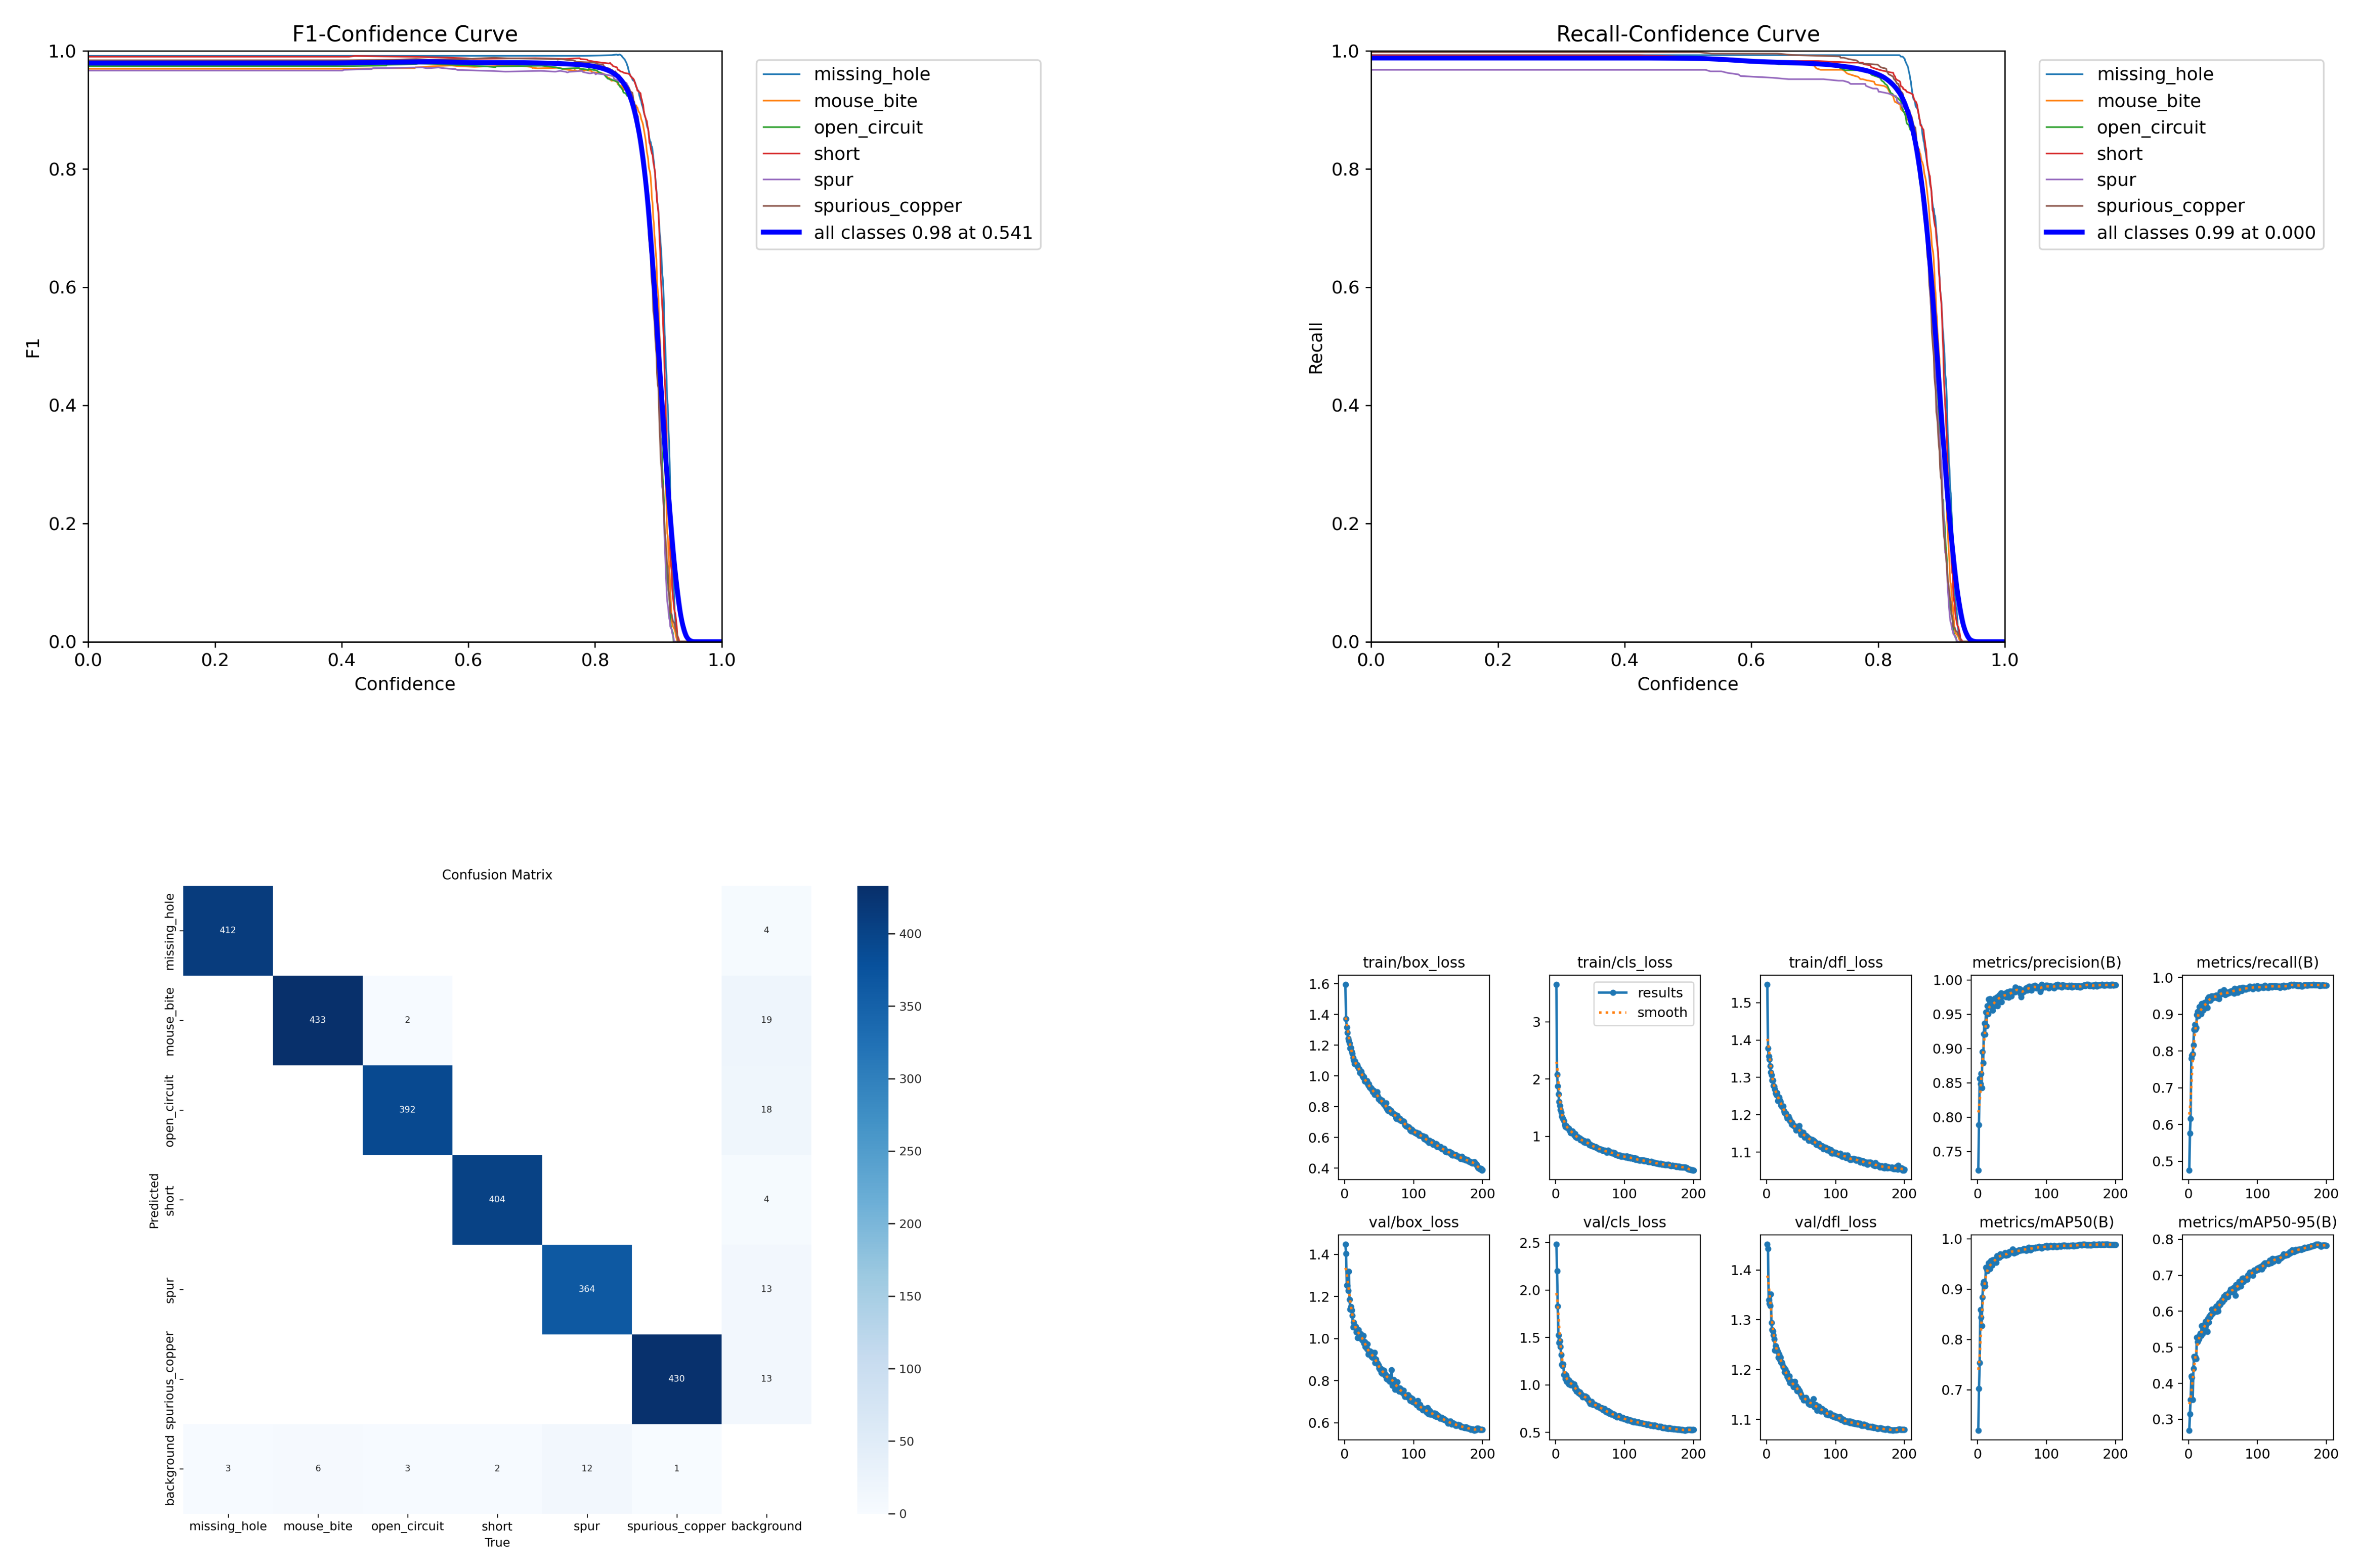

In [ ]:
directory = '/content/runs/detect/train'
selected_images = ['/content/runs/detect/train/F1_curve.png', '/content/runs/detect/train/R_curve.png', '/content/runs/detect/train/confusion_matrix.png', '/content/runs/detect/train/results.png']

fig, axs = plt.subplots(2, 2, figsize=(60, 40))

for i, ax in enumerate(axs.flat):
    image = cv2.imread(os.path.join(directory, selected_images[i]))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image_rgb)
    ax.axis('off')

plt.show()

**Matriz de confusão**  

A análise da matriz de confusão revela que o modelo conseguiu classificar corretamente a maioria das instâncias em todas as classes, com destaque para "missing_hole" e "short", onde os erros foram mínimos. No entanto, é evidente que o modelo ainda pode ser aprimorado para alcançar maior precisão em classes como "open circuit", por exemplo.

**Curvas e Métricas**  

O treinamento do modelo apresentou um desempenho sólido com melhorias consistentes em várias métricas.

A Box_loss, responsável por avaliar a precisão das caixas delimitadoras, apresentou uma redução constante ao longo do treinamento, enquanto a validação acompanhou esse comportamento, estabilizando em valores baixos e similares, sem oscilações significativas.

A Cls_loss, que mede a capacidade de classificação das instâncias, começou em valores elevados, mas convergiu rapidamente para números baixos, demonstrando boa generalização tanto nos dados de treinamento quanto de validação.

A Dfl_loss, relacionada ao refinamento das bordas das caixas, mostrou uma convergência contínua e estável, indicando que o modelo conseguiu ajustar com precisão as posições das caixas.

As métricas de precisão e recall tiveram uma evolução constante, alcançando e estabilizando em valores superiores a 95%, evidenciando a habilidade do modelo em equilibrar detecções corretas e minimizar erros.

Por fim, o mAP50 atingiu valores excepcionais, próximos de 99%, refletindo alta precisão para limites de IoU de 50%. O mAP50-95, uma métrica mais rigorosa que considera diferentes intervalos de IoU, estabilizou em torno de 80%, demonstrando a robustez geral do modelo em cenários mais desafiadores.

Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,833,954 parameters, 0 gradients, 194.4 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 115MB/s]
val: Scanning /content/PCB_Dataset/Dataset_organized/labels/test... 588 images, 0 backgrounds, 0 corrupt: 100%|██████████| 588/588 [00:00<00:00, 1291.71it/s]

val: New cache created: /content/PCB_Dataset/Dataset_organized/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:18<00:00,  1.95it/s]


                   all        588       2496      0.995      0.996      0.995      0.863
          missing_hole        102        444      0.994          1      0.994      0.864
            mouse_bite         92        390      0.994      0.995      0.995      0.877
          open_circuit        112        466      0.996      0.987      0.995       0.83
                 short        106        456      0.999          1      0.995      0.881
                  spur         92        386      0.991      0.995      0.995      0.867
       spurious_copper         84        354      0.999          1      0.995      0.859
Speed: 0.5ms preprocess, 23.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val


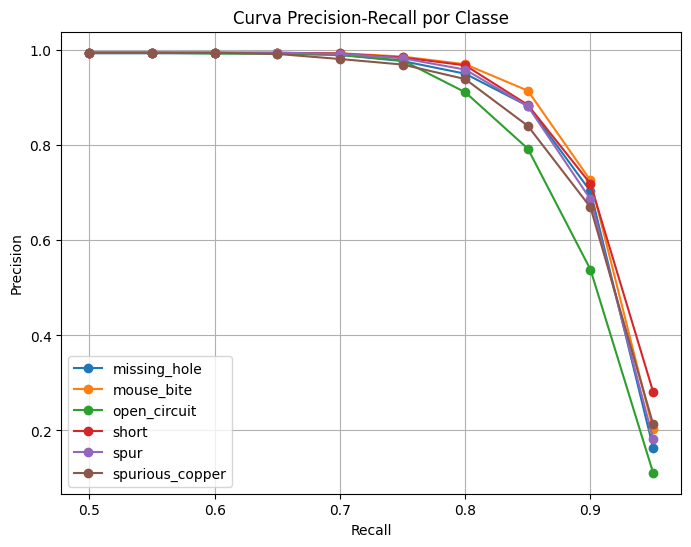

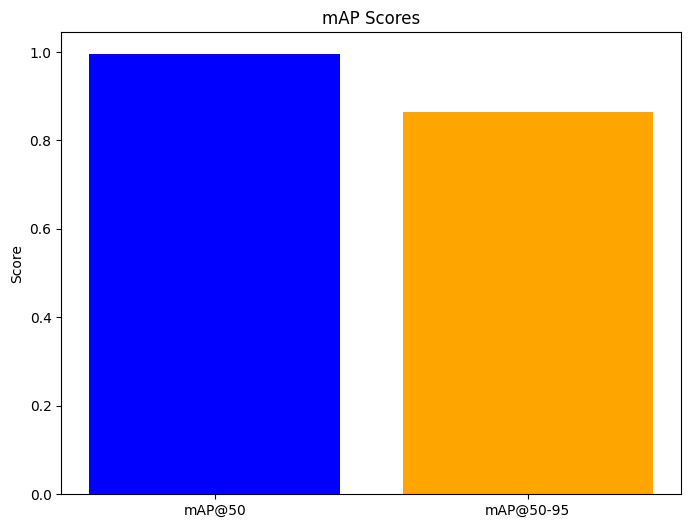

In [ ]:
results = model.val(
    imgsz=640,
    batch=16,
    conf=0.001,
    iou=0.7,
    save_json=False,
    split='test'
)

all_ap = results.box.all_ap
map50 = results.box.map50
map50_95 = results.box.map
nc = results.box.nc
class_names = model.names

test_data = '/content/PCB_Dataset/Dataset_organized/images/test'

plt.figure(figsize=(8, 6))
for i in range(nc):

    pr_curve = all_ap[i]
    plt.plot(np.linspace(0.5, 0.95, len(pr_curve)), pr_curve, marker='o', label=f"{class_names[i]}")

plt.title('Curva Precision-Recall por Classe')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['mAP@50', 'mAP@50-95'], [map50, map50_95], color=['blue', 'orange'])
plt.title('mAP Scores')
plt.ylabel('Score')
plt.show()


**Resultados de Desempenho Geral no conjunto de teste:**

    Precisão: 0.995
    Recall: 0.996
    mAP@50: 0.995
    mAP@50-95: 0.863

Estes valores indicam que o modelo está performando muito bem em termos de precisão e recall para a maioria das classes, com excelente desempenho em métricas mais rigorosas. A queda no mAP@50-95 é esperada, pois considera intervalos mais complexos de IoU.

levando em conta que o modelo tem uma media de inferência de 23.6ms por imagem, ele apresenta velocidade e resultados bem eficientes para aplicações em tempo real.

**Curva de precisão**

O gráfico da curva de precisão mostra que todas as classes começam com alta precisão (>0.9) quando o recall está abaixo de 0.8, mas sofrem uma queda acentuada quando o recall se aproxima de 1.0. A classe "Open Circuit" apresenta a maior perda de precisão, indicando dificuldades na identificação desse defeito. Já classes como "Short" e "Spurious Copper" mantêm uma precisão mais alta por um intervalo maior de recall. Para melhorar o desempenho, pode ser necessário balancear melhor o dataset ou otimizar a arquitetura do modelo.

**mAP Scores**

Observando o grafico nota-se que o modelo é capaz de detectar quase todas as instâncias com alto nível de precisão, com o mAP@50 atingindo valores proximos a 100%. Apesar do mAP50-95 ser menor, ele ainda sim atinge um bom valor, sendo em torno de 86%, sugerindo que o modelo mantém bom desempenho mesmo em condições de detecção mais rigorosas.


image 1/1 /content/PCB_Dataset/Dataset_organized/images/test/01_short_18_jpg.rf.438d1e2079b307a4d2e5954a663d7a85.jpg: 640x640 4 shorts, 18.4ms
Speed: 2.2ms preprocess, 18.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


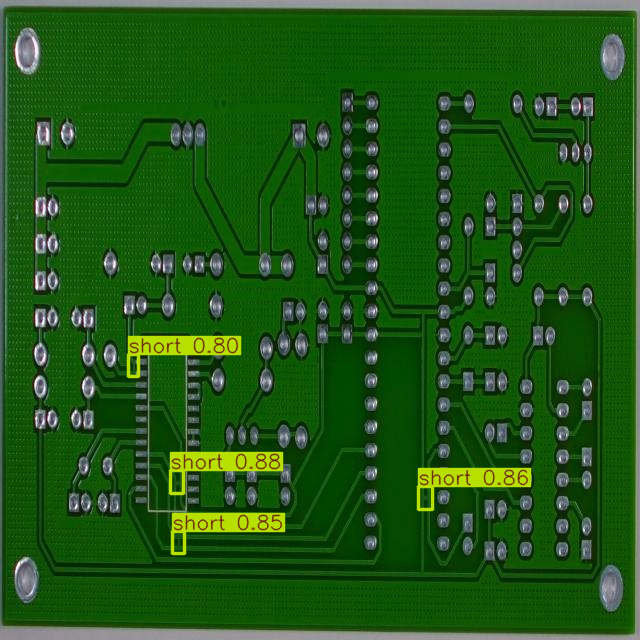


image 1/1 /content/PCB_Dataset/Dataset_organized/images/test/08_mouse_bite_04_jpg.rf.40935a72fc42d4649543f497e8188f9e.jpg: 640x640 5 mouse_bites, 21.0ms
Speed: 2.2ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


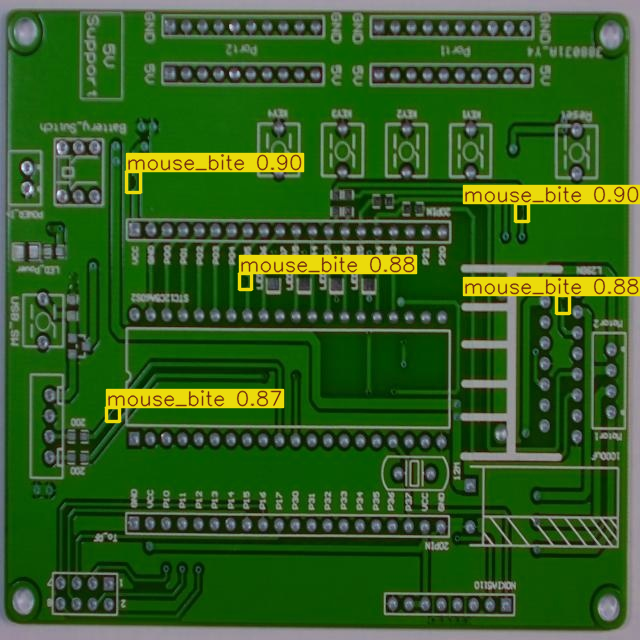


image 1/1 /content/PCB_Dataset/Dataset_organized/images/test/08_missing_hole_08_jpg.rf.519a7826a62360cb7468fd5847a4a1b8.jpg: 640x640 5 missing_holes, 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


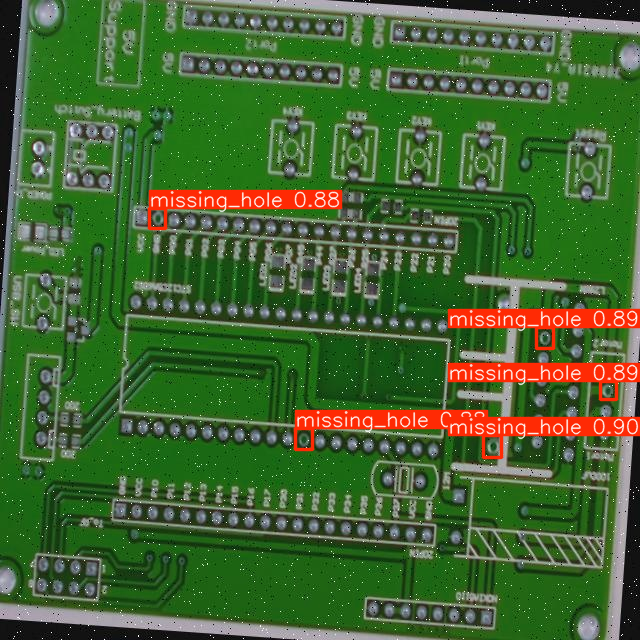


image 1/1 /content/PCB_Dataset/Dataset_organized/images/test/01_missing_hole_07.jpg: 640x640 3 missing_holes, 19.8ms
Speed: 2.1ms preprocess, 19.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


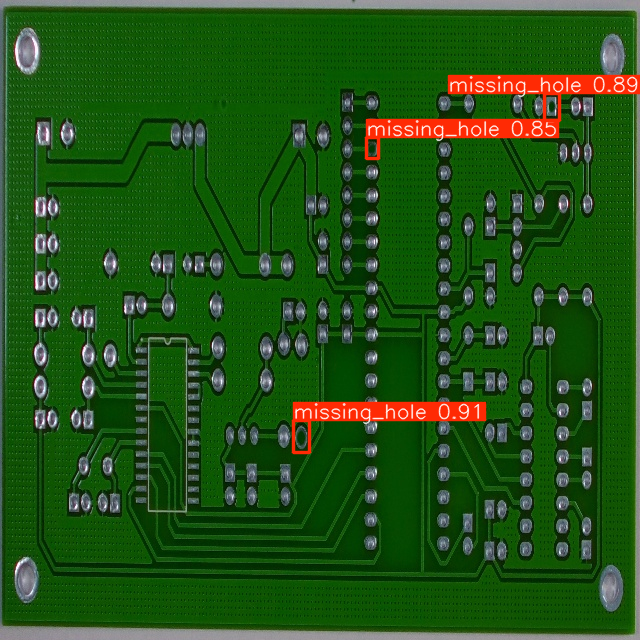


image 1/1 /content/PCB_Dataset/Dataset_organized/images/test/06_spur_05.jpg: 640x640 5 spurs, 23.2ms
Speed: 2.1ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


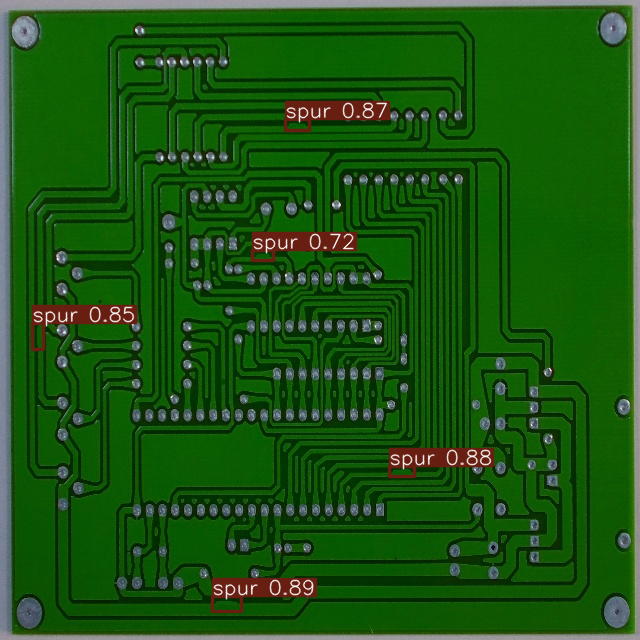


image 1/1 /content/PCB_Dataset/Dataset_organized/images/test/06_missing_hole_02_jpg.rf.582ba7956f8ba68c6ba2fdd6a139fea2.jpg: 640x640 5 missing_holes, 21.4ms
Speed: 2.1ms preprocess, 21.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


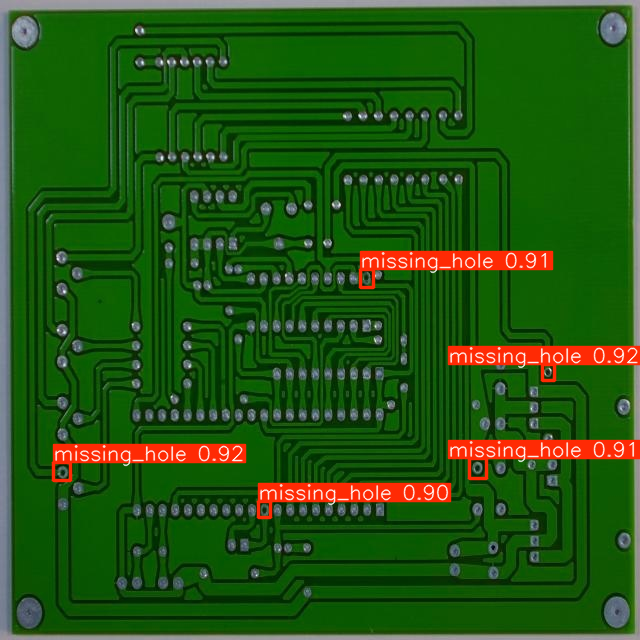

In [ ]:
image_dir = "/content/PCB_Dataset/Dataset_organized/images/test"

selected_images = random.sample(os.listdir(image_dir), 6)

def process_and_display_images(image_list, model, image_dir, conf_threshold=0.3):
    for image_name in image_list:
        image_path = os.path.join(image_dir, image_name)
        results = model.predict(image_path, conf=conf_threshold)

        img_rgb = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)
        cv2_imshow(img_rgb)

process_and_display_images(selected_images, model, image_dir)

No uso pratico utilizado no conjunto de testes, é possivel se notar que o modelo tem uma boa precisão e aceitavel nivel de confiança para localizar os defeitos propostos.

## **INTERFACE PARA USO DE IMAGENS PROPRIAS**


Utilização do Gradio, para criar uma interface que o usuario possa utilizar o modelo

Deve ser feito previamente o download do peso na aba de " IMPORTAÇÃO DO MELHOR PESO "

In [ ]:
model = YOLO('/content/best.pt')

def detect_objects(image):
    results = model(image)

    annotated_image = results[0].plot()
    return annotated_image

iface = gr.Interface(
    fn=detect_objects,
    inputs=gr.Image(type="numpy", label="Upload a photo"),
    outputs=gr.Image(type="numpy", label="PCB board defect detected"),
    title="PCB Board Defect Detection",
    description="Upload an image to detect the defects on a PCB board"
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://27447729844ea4a037.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **CORREÇÃO DE ERRO APÓS TREINAMENTO**

O codigo pode apresentar um erro ao tentar utilizar o gdow após a execução do treinamento. executar a celula a seguir para que conjunto de caracteres UTF-8 seja utilizado

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding